This Notebook is now deprecated. Please see `simple_kinematic_model.ipynb`

In [1]:
import glob as glob
import pandas as pd
import numpy as np
import torch as t

In [2]:
drone = pd.read_json('data/data_20092023-15:36:05(more_movement).json')
gcs = pd.read_json('data/data_20092023-15:39:26(less_movement).json')

# add prefix to packet type
drone['mavpackettype'] = 'UAV_' + drone['mavpackettype']
gcs['mavpackettype'] = 'GCS_' + gcs['mavpackettype']

# zero time to the beginning of the flight
drone['time_boot_ms'] -= drone['time_boot_ms'].min()
gcs['time_boot_ms'] -= gcs['time_boot_ms'].min()

# combine dataframes
df = pd.concat([drone, gcs], ignore_index=True)
df = df.sort_values(by=['time_boot_ms'], ignore_index=True)

df['time_s'] = df['time_boot_ms'] / 1000
df['lat'] = df['lat'] / 1e7 # int->float
df['lon'] = df['lon'] / 1e7
df['alt'] = df['alt'] / 1000 # orginally in mm

df['vx'] = df['vx'] / 100 # to m/s
df['vy'] = df['vy'] / 100
df['vz'] = -1*(df['vz'] / 100) # Invert z velocity. Up is now positive.
df

,mavpackettype,time_boot_ms,roll,pitch,yaw,rollspeed,pitchspeed,yawspeed,lat,lon,alt,relative_alt,vx,vy,vz,hdg,time_s
0,UAV_ATTITUDE,0,0.020393,0.012543,0.295718,-0.001011,-0.001186,-0.000113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
1,GCS_ATTITUDE,0,-0.023365,0.123523,-0.122601,0.000993,0.000395,0.000471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2,GCS_ATTITUDE,100,-0.023374,0.123501,-0.122614,-0.000150,0.000763,0.000189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100
3,UAV_ATTITUDE,100,0.020423,0.012552,0.295651,-0.000149,0.000036,-0.000859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100
4,UAV_GLOBAL_POSITION_INT,140,NaN,NaN,NaN,NaN,NaN,NaN,42.724676,-84.480802,274.12,2186.0,-0.01,-0.02,-0.00,1693.0,0.140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,GCS_ATTITUDE,76700,-0.124266,-0.072007,-1.054624,0.140474,0.046855,0.836001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.700
1996,UAV_GLOBAL_POSITION_INT,76731,NaN,NaN,NaN,NaN,NaN,NaN,42.724648,-84.480773,275.58,3642.0,0.56,-1.01,0.11,18863.0,76.731
1997,UAV_ATTITUDE,76800,-0.000866,0.011652,-3.028455,0.158962,0.122843,-0.492457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.800
1998,GCS_ATTITUDE,76800,-0.121024,-0.063388,-0.967107,0.095547,-0.017044,0.906274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.800


In [3]:
import math
import pymap3d as pm

def geodesic_distances(lat1, lon1, alt1, lat2, lon2, alt2):
    e, n, u = pm.geodetic2enu(lat1, lon1, alt1, lat2, lon2, alt2)
    return n, e, u

# Position class for managing and updating position-related data
class Position:
    def __init__(self, ref_lat, ref_lon, ref_alt):
        self.ref_lat = ref_lat
        self.ref_lon = ref_lon
        self.ref_alt = ref_alt
        self.x = None
        self.y = None
        self.z = None
        self.vx = None
        self.vy = None
        self.vz = None
        self.timestamp = None

    def update(self, lat, lon, alt, vx, vy, vz, timestamp):
        self.x, self.y, self.z = geodesic_distances(lat, lon, alt, self.ref_lat, self.ref_lon, self.ref_alt)
        self.vx = vx 
        self.vy = vy
        self.vz = vz
        self.timestamp = timestamp

    def kinematic_update(self, current_time):
        if self.timestamp is not None:
            dt = (current_time - self.timestamp)
            self.x += self.vx * dt
            self.y += self.vy * dt
            self.z += self.vz * dt
            self.timestamp = current_time

# Attitude class for managing and updating attitude-related data
class Attitude:
    def __init__(self):
        self.roll = None
        self.pitch = None
        self.yaw = None
        self.rollspeed = None
        self.pitchspeed = None
        self.yawspeed = None
        self.timestamp = None

    def update(self, roll, pitch, yaw, rollspeed, pitchspeed, yawspeed, timestamp):
        self.roll = roll
        self.pitch = pitch
        self.yaw = yaw
        self.rollspeed = rollspeed
        self.pitchspeed = pitchspeed
        self.yawspeed = yawspeed
        self.timestamp = timestamp

    def kinematic_update(self, current_time):
        if self.timestamp is not None:
            dt = (current_time - self.timestamp)
            self.roll += self.rollspeed * dt
            self.pitch += self.pitchspeed * dt
            self.yaw += self.yawspeed * dt
            self.timestamp = current_time

# Entity class for combining Position and Attitude
class Entity:
    def __init__(self, ref_lat, ref_lon, ref_alt):
        self.position = Position(ref_lat, ref_lon, ref_alt)
        self.attitude = Attitude()

# Model class for managing UAV and GCS and for providing the prediction feature
class Model:
    def __init__(self, ref_lat, ref_lon, ref_alt):
        self.uav = Entity(ref_lat, ref_lon, ref_alt)
        self.gcs = Entity(ref_lat, ref_lon, ref_alt)
        
    def relative_location(self, current_time):
        # Perform kinematic update
        self.uav.position.kinematic_update(current_time)
        self.gcs.position.kinematic_update(current_time)
        self.uav.attitude.kinematic_update(current_time)
        self.gcs.attitude.kinematic_update(current_time)
        
        # Calculate relative location
        if self.uav.position.timestamp is not None and self.gcs.position.timestamp is not None:
            delta_x = self.uav.position.x - self.gcs.position.x
            delta_y = self.uav.position.y - self.gcs.position.y
            delta_z = self.uav.position.z - self.gcs.position.z
            return {'delta_x': delta_x, 'delta_y': delta_y, 'delta_z': delta_z}
        else:
            return None  # Insufficient data to calculate

In [4]:
dt = 5 # time step in ms

gcs_start_pos = df.query('mavpackettype == "GCS_GLOBAL_POSITION_INT"').iloc[0]
ref_lat = gcs_start_pos['lat']
ref_lon = gcs_start_pos['lon']
ref_alt = gcs_start_pos['alt']

model = Model(ref_lat, ref_lon, ref_alt)

rel_x = []
rel_y = []
rel_z = []
timestamp = []

i = 0
for cur_time in np.arange(0, df.time_s.max(), dt/1000):
    # increment pointer up to the most recently updated row 
    while df.iloc[i+1]['time_s'] < cur_time: # Here Berg: Loops until row has a greater timestamp, updates model, then predicts for the past (dt is negative)
        i += 1

    row = df.iloc[i]
    if row['mavpackettype'] == 'GCS_GLOBAL_POSITION_INT':
        model.gcs.position.update(row['lat'], row['lon'], row['alt'], row['vx'], row['vy'], row['vz'], row['time_s'])
    elif row['mavpackettype'] == 'UAV_GLOBAL_POSITION_INT':
        model.uav.position.update(row['lat'], row['lon'], row['alt'], row['vx'], row['vy'], row['vz'], row['time_s'])
    elif row['mavpackettype'] == 'GCS_ATTITUDE':
        model.gcs.attitude.update(row['roll'], row['pitch'], row['yaw'], row['rollspeed'], row['pitchspeed'], row['yawspeed'], row['time_s'])
    elif row['mavpackettype'] == 'UAV_ATTITUDE':
        model.uav.attitude.update(row['roll'], row['pitch'], row['yaw'], row['rollspeed'], row['pitchspeed'], row['yawspeed'], row['time_s'])
    rel_loc = model.relative_location(cur_time)
    if rel_loc is not None:
        rel_x.append(rel_loc['delta_x'])
        rel_y.append(rel_loc['delta_y'])
        rel_z.append(rel_loc['delta_z'])
        timestamp.append(cur_time)


rel_df = pd.DataFrame({'delta_x': rel_x, 'delta_y': rel_y, 'delta_z': rel_z, 'timestamp': timestamp})

Text(0, 0.5, 'Distance (m)')

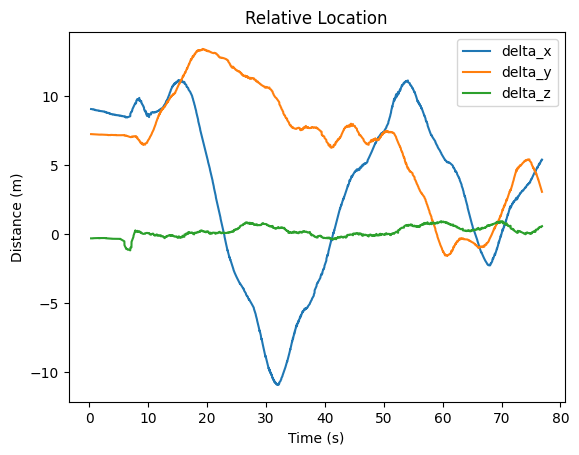

In [5]:
import matplotlib.pyplot as plt

plt.plot(rel_df['timestamp'], rel_df['delta_x'], label='delta_x')
plt.plot(rel_df['timestamp'], rel_df['delta_y'], label='delta_y')
plt.plot(rel_df['timestamp'], rel_df['delta_z'], label='delta_z')
plt.legend()
plt.title('Relative Location')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')

In [6]:
import plotly.express as px


min_value = min(rel_df.delta_y.min(), rel_df.delta_x.min())
max_value = max(rel_df.delta_y.max(), rel_df.delta_x.max())
fig = px.line_3d(rel_df, x='delta_x', y='delta_y', z='delta_z')
fig.update_layout(
    scene=dict(
        aspectmode='cube',  # this ensures that the aspect ratio is the same for x, y, and z
        xaxis=dict(nticks=10, range=[min_value, max_value]),
        yaxis=dict(nticks=10, range=[min_value, max_value]),
        zaxis=dict(nticks=10, range=[min_value*0.2, max_value*0.2])
    )
)
fig.show()


In [7]:
fig = px.line(
    rel_df,
    x='delta_x',
    y='delta_y',
)
# set same scale for x and y axes
fig.update_layout(
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
    )
)
fig.show()

Text(0.5, 1.0, 'Relative location in x-z plane')

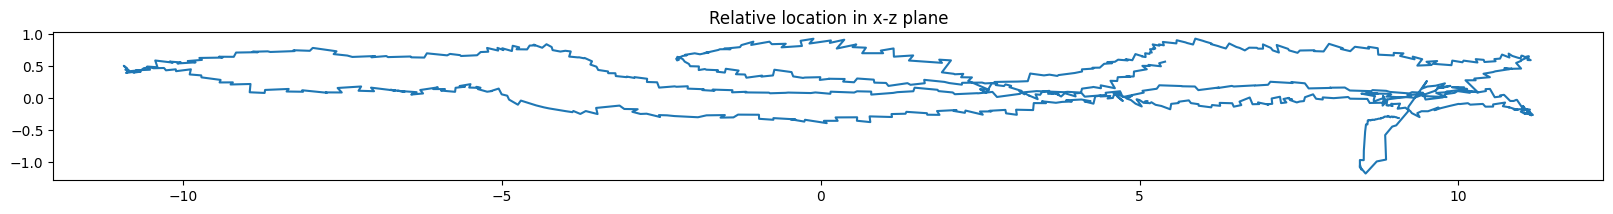

In [8]:
plt.figure(figsize=(20, 20))
plt.plot(rel_df['delta_x'], rel_df['delta_z'])
_=plt.axis('scaled')
plt.title('Relative location in x-z plane')

# Just Position, No Interpolation

In [15]:
# geodesic_distances()
uav_pos = df[df.mavpackettype.str.contains('UAV_GLOBAL_POSITION_INT')]
starting_pos = uav_pos.iloc[0]

model = Position(starting_pos.lat, starting_pos.lon, starting_pos.alt)

rel_x = []
rel_y = []
rel_z = []
timestamp = []

# for row in uav_pos.itertuples():
#     x, y, z = geodesic_distances(row.lat, row.lon, row.alt, starting_pos.lat, starting_pos.lon, starting_pos.alt)
#     rel_x.append(x)
#     rel_y.append(y)
#     rel_z.append(z)
#     timestamp.append(row.time_s)
dt = 50 # time step in ms
i = 0
for cur_time in np.arange(0, uav_pos.time_s.max(), dt/1000):
    while uav_pos.iloc[i].time_s < cur_time:
        row = uav_pos.iloc[i]
        model.update(row['lat'], row['lon'], row['alt'], row['vx'], row['vy'], row['vz'], row['time_s'])
        i += 1
    rel_loc = model.kinematic_update(cur_time)
    x, y, z, = model.x, model.y, model.z
    if None not in [x, y, z]:
        rel_x.append(x)
        rel_y.append(y)
        rel_z.append(z)
        timestamp.append(cur_time)
        

rel_df = pd.DataFrame({'delta_x': rel_x, 'delta_y': rel_y, 'delta_z': rel_z, 'timestamp': timestamp})

In [17]:
import plotly.express as px


min_value = min(rel_df.delta_y.min(), rel_df.delta_x.min())
max_value = max(rel_df.delta_y.max(), rel_df.delta_x.max())
fig = px.line_3d(rel_df, x='delta_x', y='delta_y', z='delta_z')
fig.update_layout(
    scene=dict(
        aspectmode='cube',  # this ensures that the aspect ratio is the same for x, y, and z
        xaxis=dict(nticks=10, range=[min_value, max_value]),
        yaxis=dict(nticks=10, range=[min_value, max_value]),
        zaxis=dict(nticks=10, range=[min_value*0.2, max_value*0.2])
    )
)
fig.show()


In [20]:
fig = px.scatter(
    rel_df,
    x='delta_x',
    y='delta_y',
)
# set same scale for x and y axes
# fig.update_layout(
#     xaxis=dict(
#         scaleanchor="y",
#         scaleratio=1,
#     )
# )
fig.show()